In [46]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat

from definitions import ROOT_DIR
from unc.utils import load_info

In [47]:
uf2m_u_color = 'darkorange'

all_paths = {
    'uf2a_cnn': Path(ROOT_DIR, 'results', 'uf2a_cnn'),
    'uf2m_cnn':  Path(ROOT_DIR, 'results', 'uf2m_cnn'),
    'uf2p_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf2p_cnn_lstm'),
    'uf2m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf2m_cnn_lstm'),

}

plot_info = {
    'uf2a_cnn': {'color': 'forestgreen', 'label': 'Ground-truth map'},
    'uf2p_cnn_lstm': {'color': 'lightcoral', 'label': 'LSTM + observations'},
    'uf2m_cnn_lstm': {'color': 'darkred', 'label': 'LSTM + normal mapping'},
    'uf2m_cnn_uncertainty_decay_1.0': {'color': 'black', 'label': 'Normal mapping'},
    'uf2m_cnn_uncertainty_decay_0.9': {'color': 'darkorange', 'label': 'Normal mapping + uncertainty'}
}

plot_order = [
    'uf2a_cnn',
    'uf2m_cnn_uncertainty_decay_1.0',
    'uf2p_cnn_lstm',
    'uf2m_cnn_lstm',
    'uf2m_cnn_uncertainty_decay_0.9'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [48]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
        
        reward = info['reward']
        offline_reward = info['offline_eval_reward']

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_reward, args))

    
    return all_results

    

In [49]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [50]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [51]:
raw_data.keys()

dict_keys(['uf2a_cnn', 'uf2m_cnn', 'uf2p_cnn_lstm', 'uf2m_cnn_lstm'])

In [52]:
key = 'uncertainty_decay'
split_file = 'uf2m_cnn'
uf2m_grouped = group_by(raw_data[split_file], key, split_file)

In [53]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results



In [54]:
new_raw = {}
for k, v in uf2m_grouped.items():
    new_raw[k] = v

for k, v in raw_data.items():
    if k != split_file:
        new_raw[k] = v

In [55]:
max_overs = {}
for g, v in new_raw.items():
    max_overs[g] = get_eps_max_over(v, eps_max_over=100)

In [56]:
# Get the best hyperparams based on the final 100 episodes
all_best = {}
for key, v in max_overs.items():
    all_best[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best

{'uf2m_cnn_uncertainty_decay_0.9': (args(buffer_size=100000, step_size=0.001, arch='cnn', uncertainty_decay=0.9),
  35.11016),
 'uf2m_cnn_uncertainty_decay_1.0': (args(buffer_size=100000, step_size=1e-05, arch='cnn', uncertainty_decay=1.0),
  25.897840000000002),
 'uf2a_cnn': (args(buffer_size=100000, step_size=0.0001, arch='cnn', uncertainty_decay=1.0),
  41.100319999999996),
 'uf2p_cnn_lstm': (args(buffer_size=100000, step_size=0.0001, arch='cnn_lstm', uncertainty_decay=1.0),
  4.6736),
 'uf2m_cnn_lstm': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0),
  35.590399999999995)}

In [57]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


# def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
#     all_seeds = []
#     for offline_rews, online_rews, _ in data:
#         current_seed = []
#         for length, dis_rew in zip(lengths, dis_rews):
#             current_seed.append(np.zeros(length) + dis_rew)
#         all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
#     return np.array(all_seeds)

In [58]:
# trunc = int(1e6)
all_mapped_data = {}
for key, v in all_best.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in new_raw[key][arg]]
    all_mapped_data[key] = np.stack(all_seeds)



In [59]:
all_mapped_data

{'uf2m_cnn_uncertainty_decay_0.9': array([[16.4, 16. , 15. , ..., 41. , 44.2, 36.2],
        [13.2, 11.8, 12.6, ..., 41.2, 40.6, 40.6],
        [10.4, 10.2, 12.8, ..., 36.8, 36.6, 38.6],
        [10.8, 11.4, 15.6, ..., 35.2, 34.2, 39.4],
        [11.2, 13.8, 13.8, ..., 37.6, 36.8, 36.6]]),
 'uf2m_cnn_uncertainty_decay_1.0': array([[ 8.2,  9.2, 12.2, ..., 29.8, 25.8, 33.4],
        [ 4.8, 11.6, 12.4, ..., 25.8, 29.4, 27.2],
        [ 3.2, 10. , 12.6, ..., 33.6, 27.6, 35.2],
        [11.8, 11.2,  9.4, ..., 27.4, 33.2, 29.8],
        [12.2, 11.4,  4. , ..., 27.8, 33.8, 33.6]]),
 'uf2a_cnn': array([[16.2, 15. , 21.4, ..., 46.4, 43.4, 40.8],
        [11.6, 18.4, 14.8, ..., 42.2, 44.8, 40.2],
        [16.6, 22.8, 14.8, ..., 44.8, 45.8, 40.4],
        [13.8, 16.4, 19.2, ..., 44.4, 42.6, 42.4],
        [14.2, 14.4, 22.8, ..., 38.2, 46. , 45.4]]),
 'uf2p_cnn_lstm': array([[ 3.2,  0.8,  3.8, ...,  1.8,  3.2,  6.8],
        [ 0.8,  4.4,  6.8, ...,  4.4,  5. ,  3.4],
        [ 2. ,  0.8,  2.4, ...

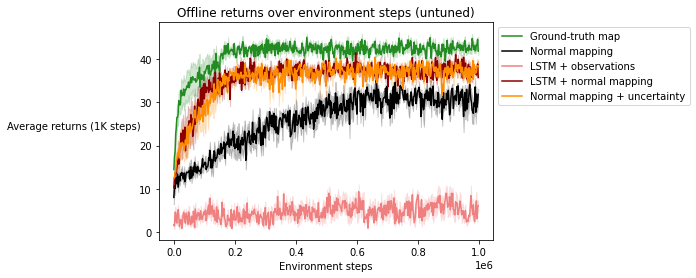

In [60]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (untuned)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

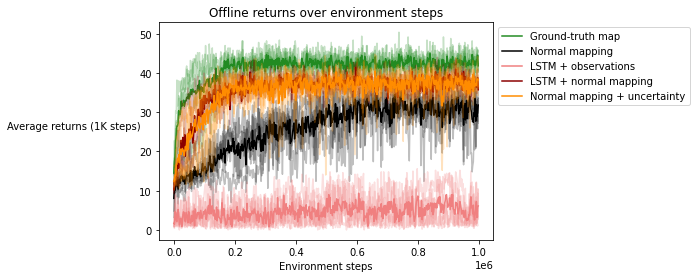

In [61]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0) 

    ax.plot(x, means, label=key, color=color)
    for d in data:
        ax.plot(x, d, color=color, alpha=0.25)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')